**Connect google drive**

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Sat Aug 29 09:52:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'Getting started.pdf'  'My Drive'  'Proposal Skripsi.gdoc'   Work   yolov3


**1) Clone the Darknet**



In [3]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14263, done.
remote: Total 14263 (delta 0), reused 0 (delta 0), pack-reused 14263
Receiving objects: 100% (14263/14263), 12.85 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (9725/9725), done.


**2) Compile Darknet using Nvidia GPU**


In [4]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

**3) Configure Darknet network for training YOLO V3**

In [5]:
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [6]:
## 2 classes
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
# !sed -i 's/height=416/height=128/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/yolov3_training.cfg
!sed -i 's/steps=400000,450000/steps=4800,5400/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=24@' cfg/yolov3_training.cfg

## 1 classes
# !sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
# !sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
# !sed -i 's/max_batches = 500200/max_batches = 4000/' cfg/yolov3_training.cfg
# !sed -i '610 s@classes=80@classes=1@' cfg/yolov3_training.cfg
# !sed -i '696 s@classes=80@classes=1@' cfg/yolov3_training.cfg
# !sed -i '783 s@classes=80@classes=1@' cfg/yolov3_training.cfg
# !sed -i '603 s@filters=255@filters=18@' cfg/yolov3_training.cfg
# !sed -i '689 s@filters=255@filters=18@' cfg/yolov3_training.cfg
# !sed -i '776 s@filters=255@filters=18@' cfg/yolov3_training.cfg

In [7]:
# Create folder on google drive so that we can save there the weights
!mkdir "/mydrive/yolov3"

mkdir: cannot create directory ‘/mydrive/yolov3’: File exists


In [8]:
!echo -e "rank\nplayer_data\nrank_1" > data/obj.names
!echo -e 'classes= 3\ntrain = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3' > data/obj.data
!mkdir data/obj

In [9]:
# Download weights darknet model 53
# !wget https://pjreddie.com/media/files/darknet53.conv.74

**4) Extract Images**

The images need to be inside a zip archive called "images.zip" and they need to be inside the folder "yolov3" on Google Drive

In [10]:
!unzip /mydrive/yolov3/PUBGM_Result.zip -d data/obj

Archive:  /mydrive/yolov3/PUBGM_Result.zip
  inflating: data/obj/sample1.png    
  inflating: data/obj/sample1.txt    
  inflating: data/obj/sample3.jpg    
  inflating: data/obj/sample3.txt    
  inflating: data/obj/sample6.jpg    
  inflating: data/obj/sample6.txt    
  inflating: data/obj/sample7.jpg    
  inflating: data/obj/sample7.txt    
  inflating: data/obj/sample8.jpg    
  inflating: data/obj/sample8.txt    
  inflating: data/obj/sample9.jpg    
  inflating: data/obj/sample9.txt    
  inflating: data/obj/pubgr1.jpg     
  inflating: data/obj/pubgr1.txt     
  inflating: data/obj/pubgr2.jpg     
  inflating: data/obj/pubgr2.txt     
  inflating: data/obj/pubgr3.jpg     
  inflating: data/obj/pubgr3.txt     


In [11]:
import glob
images_list = glob.glob("data/obj/*[jpg|png|jpeg]")
print(images_list)

['data/obj/sample6.jpg', 'data/obj/pubgr2.jpg', 'data/obj/pubgr3.jpg', 'data/obj/sample1.png', 'data/obj/pubgr1.jpg', 'data/obj/sample9.jpg', 'data/obj/sample3.jpg', 'data/obj/sample7.jpg', 'data/obj/sample8.jpg']


In [12]:
#Create training.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(images_list)) 
file.close() 

**6) Start the training**

In [13]:
# Start the training
!./darknet detector train data/obj.data cfg/yolov3_training.cfg /mydrive/yolov3/pubgm_result/yolov3_training_pubgm_result_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.885753, GIOU: 0.883485), Class: 0.999640, Obj: 0.965141, No Obj: 0.000665, .5R: 1.000000, .75R: 0.961538, count: 26, class_loss = 0.176913, iou_loss = 0.245301, total_loss = 0.422214 
 total_bbox = 3594244, rewritten_bbox = 0.535217 % 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.815335, GIOU: 0.813108), Class: 0.972135, Obj: 0.927889, No Obj: 0.016443, .5R: 0.961538, .75R: 0.730769, count: 52, class_loss = 1.477878, iou_loss = 0.586479, total_loss = 2.064358 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.882173, GIOU: 0.880010), Class: 0.999875, Obj: 0.995592, No Obj: 0.007871, .5R: 1.000000, .75R: 1.000000, count: 85, class_loss = 0.016088, iou_loss = 0.551226, total_loss = 0.567314 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.873273, GIOU: 0.872007), Class: 0.999552, Obj: 0.981707, No

In [20]:
import cv2
import matplotlib.pyplot as plt

In [33]:
!./darknet detector test data/obj.data cfg/yolov3_training.cfg /mydrive/yolov3/yolov3_training_last.weights -thresh 0.25

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001

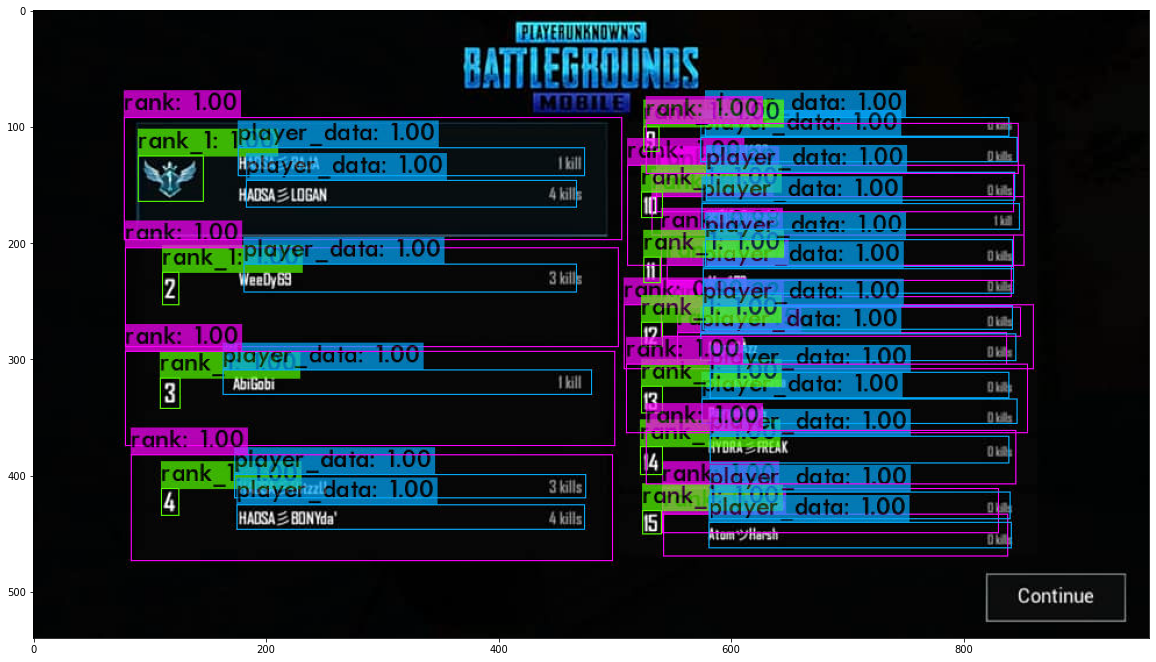

In [34]:
img = cv2.imread('predictions.jpg')
plt.figure(figsize=(20,20))
plt.imshow(img)